In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import nest
import numpy as np
import re
import os

from pynestml.frontend.pynestml_frontend import generate_nest_target

NEST_SIMULATOR_INSTALL_LOCATION = nest.ll_api.sli_func("statusdict/prefix ::")

/home/winkrobed/miniconda3/envs/nest_33_ehp/lib/python3.10/site-packages/nest/ll_api.py:42: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 1.23.0)
  import scipy



              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.3
 Built: Sep 12 2022 04:40:40

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [2]:
module_name = "edlif_psc_alpha_0_module"
nest.Install(module_name)


May 24 13:54:55 Install [Info]: 
    loaded module edlif_psc_alpha_0_module


In [3]:
def experiment(epochs:int = 5000, 
              seed: int = 1,
              poisson_rate: float = 50,
              n_pre_neurons: int = 1000,
              n_post_neurons: int= 100,
              mean_current: float = 545,
              std_current: float = 40,
              neuron_model: str = "edlif_psc_alpha_percent0_nestml__with_ed_stdp0_nestml",
              syn_spec: dict = {"synapse_model": "ed_stdp0_nestml__with_edlif_psc_alpha_percent0_nestml",
                               "alpha": 0.5,
                               "mu_minus": 0,
                               "mu_plus": 0,
                               "lambda": 0.01,
                               "eta": 50},
              sim_time: float = 1):
    # reset kernel
    nest.ResetKernel()
    # set seeds
    nest.rng_seed = seed
    np.random.seed(seed)
    # create neurons
    
    noisep = nest.Create('poisson_generator', n_pre_neurons+n_post_neurons*2)
    noisep.rate= 1
    noisem = nest.Create('poisson_generator', n_pre_neurons+n_post_neurons*2)
    noisem.rate= 1
    neuron_pre = nest.Create(neuron_model, n_pre_neurons)
    neuron_post = nest.Create(neuron_model, n_post_neurons)
    neuron_post_post = nest.Create(neuron_model,n_post_neurons)
    
    for neuron in [neuron_pre, neuron_post,neuron_post_post]:
        neuron.tau_m = 20 #20
        neuron.V_th = 15
        neuron.V_reset = 10
        neuron.tau_syn_ex = 6
        neuron.tau_syn_in = 6
        neuron.C_m = 250 #250
        neuron.t_ref = 2 #2
        # energy params
        neuron.K_ATP = 1
        neuron.gamma = 50
        neuron.tau_ap = 60
        neuron.E_ap = 4.1
        neuron.E_rp = 5
        neuron.E_hk = 5
        neuron.E_syn_ex = 0.5
        neuron.E_syn_in = 0.5
        neuron.tau_syn_atp_ex = 60
        neuron.tau_syn_atp_in = 60
        
    # **OBS** post synaptic neurons also has his own I_e
    

    # recorders
    sr_post = nest.Create("spike_recorder")
    nest.Connect(neuron_post, sr_post)
    sr_post_post = nest.Create("spike_recorder")
    nest.Connect(neuron_post_post, sr_post_post)
    sr_pre = nest.Create("spike_recorder")
    nest.Connect(neuron_pre, sr_pre)
    mult = nest.Create('multimeter',
                      params={"record_from": ['V_m', 'V_abs', 'ATP', 'E_ap_tr', 'homeostatic_s_enabled', 'alp', 'bet', 'I_kernel_in__X__inh_spikes', 'I_kernel_in__X__inh_spikes__d', 'I_kernel_ex__X__exc_spikes', 'I_kernel_ex__X__exc_spikes__d', 'ATP_kernel_ex__X__exc_spikes', 'ATP_kernel_in__X__inh_spikes', 'E_syn_c', 'E_ap_c', 'ATP_c', 'ATP_s', 'post_trace_kernel__for_ed_stdp0_nestml__X__post_spikes__for_ed_stdp0_nestml']})
    # nest.Connect(mult, neuron_pre)
    nest.Connect(mult, neuron_post)
    nest.Connect(mult, neuron_post_post)
    nest.Connect(noisep, neuron_pre+ neuron_post + neuron_post_post, conn_spec = {'rule': 'one_to_one'}, syn_spec={"weight": 40.0, "delay": 1.5})
    nest.Connect(noisem, neuron_pre+ neuron_post + neuron_post_post, conn_spec = {'rule': 'one_to_one'}, syn_spec={"weight": -40.0, "delay": 1.5})
    wr = nest.Create("weight_recorder")
    nest.CopyModel(syn_spec["synapse_model"], "stdp", 
                  {"weight_recorder": wr})
    # conn_spec = {'rule':'fixed_total_number', 'N':n_pre_neurons}
    
    # w = np.random.random(n_pre_neurons)*100
    nest.Connect(neuron_pre, neuron_post,# conn_spec= conn_spec,
                 syn_spec={"synapse_model": "stdp", #'w':w
                           })
    # w = np.random.random(n_pre_neurons)*100
    nest.Connect(neuron_pre, neuron_post_post,# conn_spec= conn_spec,
                 syn_spec={"synapse_model": "stdp", #'w':w
                           })
    
    syn = nest.GetConnections(source=neuron_pre,
                         target=neuron_post,
                         synapse_model="stdp")
    syn_post = nest.GetConnections(source=neuron_post,
                         target=neuron_post_post,
                         synapse_model="stdp")
    #print(syn)
    for param, value in syn_spec.items():
        if param != "synapse_model":
            nest.SetStatus(syn, {param: value})
            nest.SetStatus(syn_post, {param: value})
    actual_sim_time = 0.0
    generator = nest.Create("spike_generator", n_pre_neurons, {"spike_times": [1,1001,2001,3001,4001], "spike_weights": [545]*5})
    nest.Connect(generator, neuron_pre, conn_spec= {'rule': 'one_to_one'})
    
    for i in range(epochs):
        print(f'Simulation N°: {i+1}')
        # generator.spike_times = [actual_sim_time+1]
        nest.Simulate(sim_time)
        actual_sim_time+=sim_time
    sr_pre = sr_pre.get("events")
    sr_post = sr_post.get("events")
    sr_post_post = sr_post_post.get("events")
    mult = mult.get("events")
    wr = wr.get("events")
    fin_weights = nest.GetConnections(synapse_model="stdp").get('w')
    return sr_pre, sr_post, mult, wr, fin_weights

In [4]:
def plots(mult, wr, eta, fin_weights, eq_energy_level):

    plt.figure()
    plt.title(fr"$\eta$ = {eta}")
    plt.xlabel("time (ms)")
    plt.ylabel("ATP")
    plt.plot(mult['times'], mult['ATP'])
    plt.axhline(eq_energy_level, c='grey', ls='--')

    plt.figure()
    plt.title(fr"$\eta$ = {eta}")
    plt.xlabel("time (ms)")
    plt.ylabel("Voltage")
    plt.plot(mult['times'], mult['V_m'])
    
    plt.figure()
    plt.title(fr"$\eta$ = {eta}")
    plt.xlabel("time (ms)")
    plt.ylabel("Current")
    plt.plot(mult['times'], mult['I_kernel_in__X__inh_spikes'])
    
    plt.figure()
    plt.title(fr"$\eta$ = {eta}")
    plt.xlabel("time (ms)")
    plt.ylabel("Current")
    plt.plot(mult['times'], mult['I_kernel_in__X__inh_spikes__d'])
    
    plt.figure()
    plt.title(fr"$\eta$ = {eta}")
    plt.xlabel("time (ms)")
    plt.ylabel("Current")
    plt.plot(mult['times'], mult['I_kernel_ex__X__exc_spikes'])
    
    plt.figure()
    plt.title(fr"$\eta$ = {eta}")
    plt.xlabel("time (ms)")
    plt.ylabel("Current")
    plt.plot(mult['times'], mult['I_kernel_ex__X__exc_spikes__d'])

    plt.figure()
    plt.title(fr"$\eta$ = {eta}")
    plt.xlabel("time (ms)")
    plt.ylabel("Weights")
    plt.plot(wr['times'], wr['weights'], '.')

    plt.figure()
    plt.xlabel("Weights")
    plt.ylabel("Frequency")
    plt.title(fr"$\eta$ = {eta}")
    plt.hist(fin_weights)    

In [5]:
def equall_dep_pot_energy_level(eta: float, alpha: float = 0.5, a_h: float = 100):
    """gives A* that is achieve when depression and 
    potentiation has the same energy level"""
    if eta == 0:
        return 0
    else:
        return a_h*(np.log(alpha)/eta + 1)


May 24 13:54:56 ConnectionManager [Warning]: 
    New connections created, connection descriptors previously obtained using 
    'GetConnections' are now invalid.
Simulation N°: 1
Simulation N°: 2
Simulation N°: 3

May 24 13:54:56 NodeManager::prepare_nodes [Info]: 
    Preparing 4011 nodes for simulation.

May 24 13:54:56 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 4011
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

May 24 13:55:01 SimulationManager::run [Info]: 
    Simulation finished.

May 24 13:55:01 NodeManager::prepare_nodes [Info]: 
    Preparing 4011 nodes for simulation.

May 24 13:55:01 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 4011
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

May 24 13:55:05 SimulationManager::run [Info]: 
    Simulation finished.

May 24 13:55:05 NodeManager::prepare_nodes [Info]: 
    Preparing 4011 nodes for simulation.

May 24

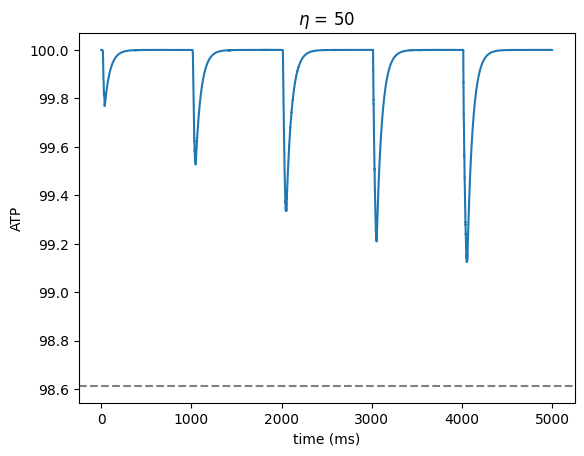

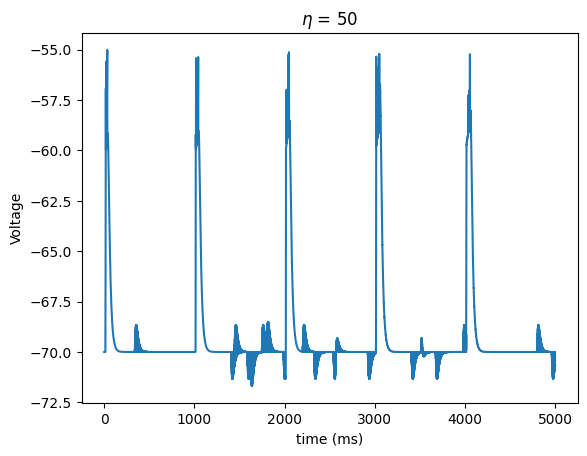

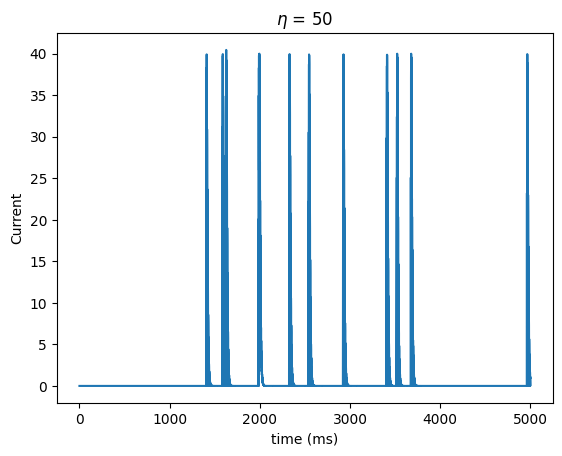

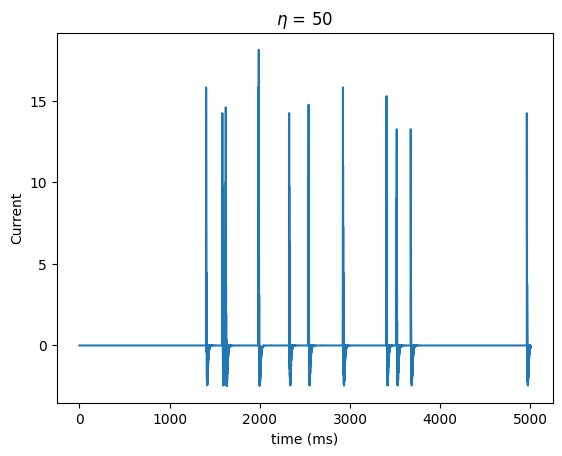

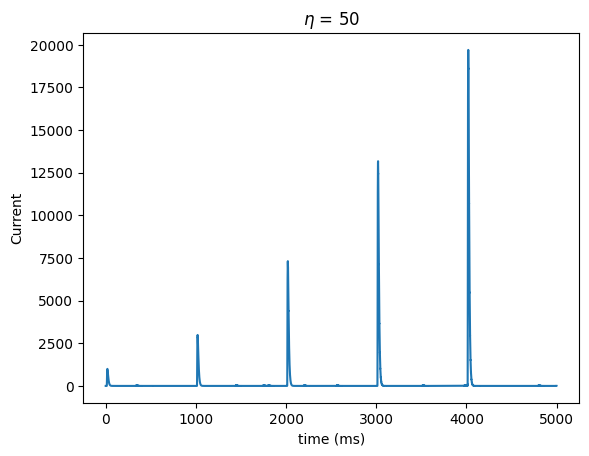

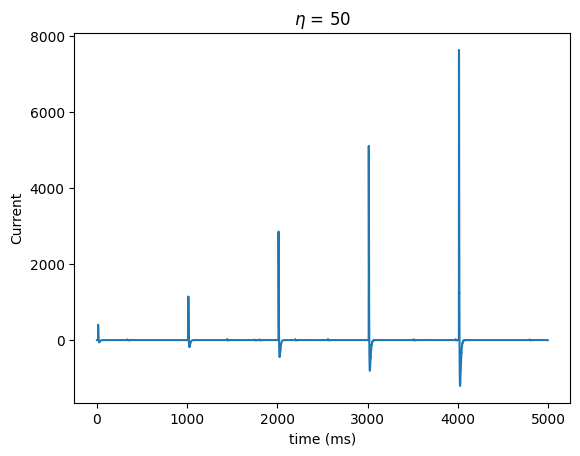

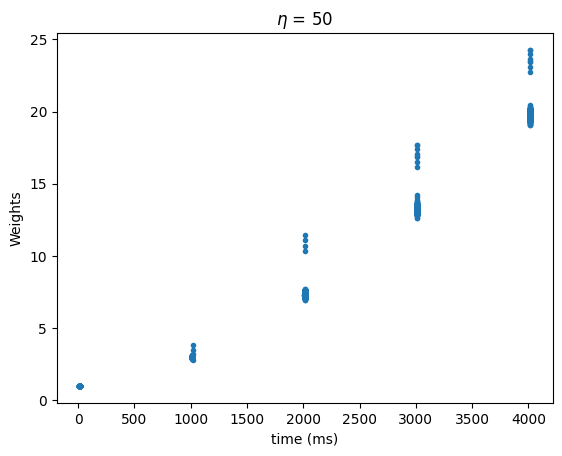

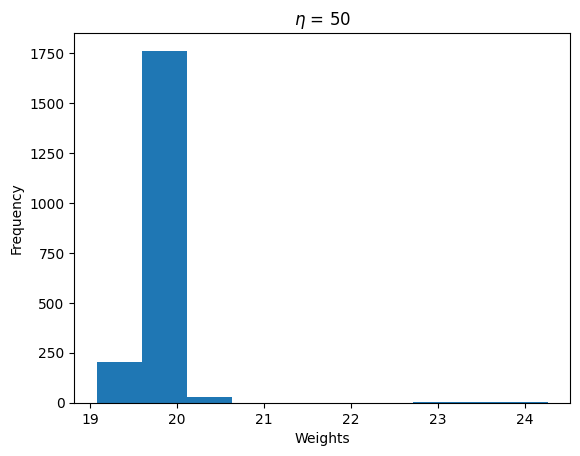

In [6]:
sim_time = 1000
eta = 50
n_pre_neurons = 1000
n_post_neurons= 1
alpha = 0.5
mu_plus = 0.0
mu_minus = 0.0

syn_spec = {"synapse_model": "ed_stdp0_nestml__with_edlif_psc_alpha_percent0_nestml",
           "alpha": alpha,
           "mu_minus": mu_minus,
           "mu_plus": mu_plus,
           "lambda": 0.01,
           "eta": eta}

eq_energy_level = equall_dep_pot_energy_level(eta=eta,
                                              alpha=alpha,
                                              a_h=100)

sr_pre, sr_post, mult, wr, fin_weights = experiment(epochs=5,
                                       poisson_rate=10,
                                       n_pre_neurons=n_pre_neurons,
                                       n_post_neurons=n_post_neurons,
                                       sim_time=sim_time,
                                       syn_spec=syn_spec)


plots(mult=mult, 
      wr=wr, 
      eta=eta, 
      fin_weights=fin_weights, 
      eq_energy_level=eq_energy_level)


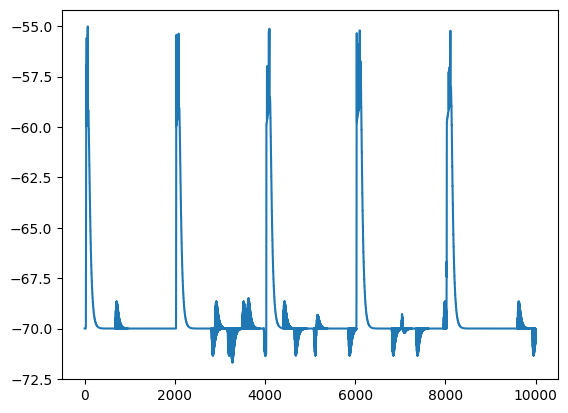

In [7]:
plt.plot(mult['V_m'])

[1.000e+00 2.000e+00 3.000e+00 ... 4.997e+03 4.998e+03 4.999e+03]


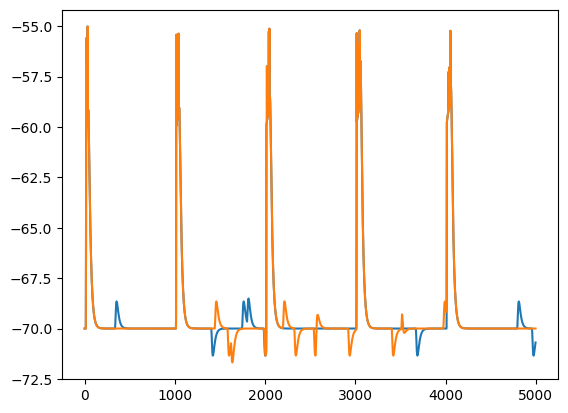

In [8]:
plt.plot(mult['V_m'][1::2])
plt.plot(mult['V_m'][0::2])
print(mult['times'][1::2])

In [9]:
defaults =nest.GetDefaults("edlif_psc_alpha_percent0_nestml__with_ed_stdp0_nestml")
print("Available state variables: edlif_psc_alpha_percent0_nestml__with_ed_stdp0_nestml", ":", defaults["recordables"])

defaults =nest.GetDefaults("iaf_psc_exp")
print("Available state variables: iaf_psc_exp", ":", defaults["recordables"])

Available state variables: edlif_psc_alpha_percent0_nestml__with_ed_stdp0_nestml : ('V_m', 'V_abs', 'ATP', 'E_ap_tr', 'homeostatic_s_enabled', 'alp', 'bet', 'I_kernel_in__X__inh_spikes', 'I_kernel_in__X__inh_spikes__d', 'I_kernel_ex__X__exc_spikes', 'I_kernel_ex__X__exc_spikes__d', 'ATP_kernel_ex__X__exc_spikes', 'ATP_kernel_in__X__inh_spikes', 'E_syn_c', 'E_ap_c', 'ATP_c', 'ATP_s', 'post_trace_kernel__for_ed_stdp0_nestml__X__post_spikes__for_ed_stdp0_nestml')
Available state variables: iaf_psc_exp : ('I_syn_ex', 'I_syn_in', 'V_m')


In [10]:
# sim_time= 2500
# eq_energy_level = equall_dep_pot_energy_level(eta=eta,
#                                               alpha=alpha,
#                                               a_h=100)
# sr_pre, sr_post, mult, wr, fin_weights = experiment(epochs=1,
#                                        poisson_rate=10,
#                                        n_pre_neurons=n_pre_neurons,
#                                        sim_time=sim_time,
#                                        syn_spec=syn_spec)


# plots(mult=mult, 
#       wr=wr, 
#       eta=eta, 
#       fin_weights=fin_weights, 
#       eq_energy_level=eq_energy_level)